## Wisconsin Breast Cancer dataset

In [1]:
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Step1: Let's import some cancer data from the web
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)
print(df.shape)
# First off, let's get some intuition about our dataset
print(df.head())
#print(df.describe())
#print(df.isnull().sum(axis=0))


(569, 32)
         0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9   ...     22     23      24      25      26      27      28      29  \
0  0.14710  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       30       31  
0  0.4601  0.11890  
1  0.2750  0.089

In [2]:
import numpy as np
# need to clean-up the column with M's and B's
print(np.unique(df.iloc[:,1]))
# 'B' is benign
# 'M' is malignant 

['B' 'M']


In [3]:
# Step 2: put 30 features into X, and munge y
# Let's use LabelEncoder to help with changing 'B','M' into numbers
print(type(df))

from sklearn.preprocessing import LabelEncoder

X = df.loc[:,2:].values

print(X.shape)

y = df.loc[:,1].values

le = LabelEncoder()     # instantiate the object 
y = le.fit_transform(y) # do two steps here, fit(), then transform()

#print(y)
#print(df.tail(3))

# Check 'M' malignant is 1 and 'B' benign is 0
le.transform(['M','B'])

<class 'pandas.core.frame.DataFrame'>
(569, 30)


array([1, 0], dtype=int64)

In [4]:
type(X)

numpy.ndarray

In [5]:
# Step3: now, let's split our data into training and test sets
#from sklearn.cross_validation import train_test_split # this is DeprecationWarning
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    stratify=y,
                                                    random_state = 1)

print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


## Combining transformers and estimators into a pipeline

In [6]:
# Step4: scale data so each feature has mean zero, std one.
# Step5: compress original 30 features into 2-dimension space via PCA
# Here we introduce "Pipeline" to help streamline 
# the: scaling(StandardScaler), compression(PCA), 
# modeling(LogisticRegression) steps

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
#from sklearn.decomposition import KernelPCA

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),      # Step 4
                    ('pca', PCA(n_components = 2)), # Step 5
                    ('clf', LogisticRegression(random_state=1))]) # Step 6

pipe_lr.fit(X_train, y_train) 

print('Test Accuracy: %0.6f' % pipe_lr.score(X_test, y_test)) # Step 7 evaluate


Test Accuracy: 0.956140


C:\Users\charl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Cross-validation two methods to assess model performance 
## The k-Fold cross-validation (and stratified sampling) 

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# StratifiedKFold cross-validation example
import numpy as np

from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10, 
                       random_state = 1).split(X_train, y_train)

scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])    
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Accuracy %0.3f' % (k+1, 
           np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Accuracy 0.935
Fold: 2, Class dist.: [256 153], Accuracy 0.935
Fold: 3, Class dist.: [256 153], Accuracy 0.957
Fold: 4, Class dist.: [256 153], Accuracy 0.957
Fold: 5, Class dist.: [256 153], Accuracy 0.935
Fold: 6, Class dist.: [257 153], Accuracy 0.956
Fold: 7, Class dist.: [257 153], Accuracy 0.978
Fold: 8, Class dist.: [257 153], Accuracy 0.933
Fold: 9, Class dist.: [257 153], Accuracy 0.956
Fold: 10, Class dist.: [257 153], Accuracy 0.956


In [10]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.014


In [11]:
# Using cross_val_score() for more succinct code
from sklearn.model_selection import cross_val_score # uses stratified k-fold cross-validation

scores = cross_val_score( estimator = pipe_lr,
                        X = X_train,
                        y = y_train,
                        cv = 10,
                        n_jobs = 1)

print('CV accuracy scores: %s' % scores)
print('Mean CV: %.3f' % np.mean(scores))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
Mean CV: 0.950


In [12]:
# Now, let's go back to to powerpoint slides again to do "Learning" and "Validation" Curves.

In [13]:
# Let's do one Learning Curve together, p. 181
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([
        ('scl', StandardScaler()),
#        ('pca', PCA(n_components = 2)),
        ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = learning_curve( estimator = pipe_lr,
                                                       X = X_train,
                                                       y = y_train,
                                                       train_sizes = np.linspace(0.1, 1.0, 10), # 10 evenly spaced intervals 
                                                       cv = 10,
                                                       n_jobs = 1)


Text(0.5, 1.0, 'Learning Curve')

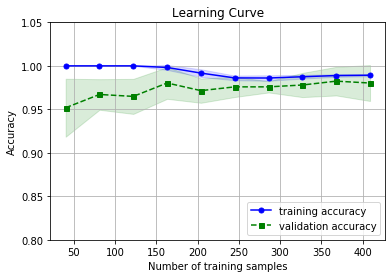

In [14]:
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores, axis = 1)
test_mean  = np.mean(test_scores, axis = 1)
test_std  = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean, 
         color = 'blue', marker = 'o', 
         markersize = 5, 
         label = 'training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, 
                              train_mean - train_std,
                              alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean, 
         color = 'green', linestyle = '--',  
         marker = 's', markersize = 5, 
         label = 'validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, 
                              test_mean - test_std,
                              alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.05])
plt.title('Learning Curve')

## Overfitting and underfitting with Validation Curves 

Text(0.5, 1.0, 'Validation Curve')

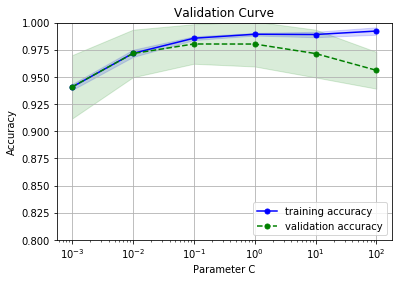

In [15]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # comparative statics 

train_scores, test_scores = validation_curve(
                        estimator = pipe_lr,
                        X = X_train,
                        y = y_train,
                        param_name = 'clf__C',
                        param_range = param_range, 
                        cv = 10)

train_mean = np.mean(train_scores, axis = 1)
train_std   = np.std(train_scores, axis = 1)

test_mean = np.mean(test_scores, axis = 1)
test_std   = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean, 
         color = 'blue', marker = 'o', 
         markersize = 5, 
         label = 'training accuracy')
plt.fill_between(param_range, train_mean + train_std, 
                              train_mean - train_std,
                              alpha = 0.15, color = 'blue')

plt.plot(param_range, test_mean, 
         color = 'green', linestyle = '--',
         marker = 'o', markersize = 5, 
         label = 'validation accuracy')
plt.fill_between(param_range, test_mean + test_std, 
                              test_mean - test_std,
                              alpha = 0.15, color = 'green')

plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.title('Validation Curve')

## Fine-tuning ML with Grid Search

In [16]:
# Grid search is a brute force exhaustive searching paradigm
# specify list of hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()), 
                     ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 10,
                 n_jobs = -1)

gs = gs.fit(X_train, y_train) 

print(gs.best_score_)
print(gs.best_estimator_)



0.9846153846153847
Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=1, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [17]:
# Take the best estimator, refit to the training data, 
# check performance and go with it! 

clf = gs.best_estimator_

clf.fit(X_train, y_train)

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


# Algorithm selection with nested cross-validation

In [18]:
# GridSearchCV
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=2)

scores = cross_val_score(gs, X_train, y_train,
                        scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [19]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                    param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}],
                    scoring='accuracy',
                    cv=2)

scores = cross_val_score(gs, X_train, y_train,
                        scoring = 'accuracy', cv = 5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) 

print(gs.fit(X_train, y_train).best_estimator_)

CV accuracy: 0.934 +/- 0.016
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')


# Different Performance Metrics
# (1) Confusion Matrix
# (2) Precision and Recall
# (3) ROC/AUM
# (4) for multi-class One vs All (AvsO)


In [20]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)

print(confmat)

[[71  1]
 [ 2 40]]


Total number of predictions: 114


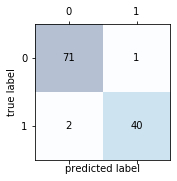

In [21]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, 
               s = confmat[i,j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
print('Total number of predictions:', len(y_pred))
# false-positives, remember "false, 'predicted' positive"  (in confmat 1)
# false-negatives, remember "false, 'predicted' negative"  (in confmat 2)

In [22]:
# Optimizing the precision and recall of a classification model
# ERR = (FP + FN) / (FP+FN + TP+TN)     <- "error"
# ACC = (TP + FN) / (FP+FN + TP+TN)     <- "acccuracy"
# ACC = 1 - ERR

# TPR (true positive rate)  =  TP/N = TP / (FN+TP) 
# FPR (false positive rate) =  FP/N = FP / (FP+TN)

In [23]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.pipeline import make_pipeline

In [24]:
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2',
                                         random_state=1,
                                         C=100.0))

X_train2 = X_train[:,[4,14]]

cv = list(StratifiedKFold(n_splits=3,
                         random_state=1).split(X_train, y_train))

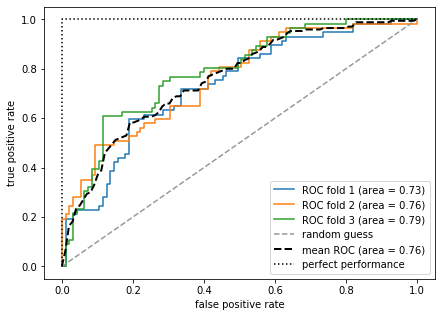

In [25]:
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr= []

for i, (train, test) in enumerate(cv):
  probas = pipe_lr.fit(X_train2[train], 
                       y_train[train]).predict_proba(X_train2[test])
  fpr, tpr, thresholds = roc_curve(y_train[test], 
                                  probas[:,1],
                                  pos_label=1)
  mean_tpr += interp(mean_fpr, fpr, tpr)
  mean_tpr[0] = 0.0
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, 
          label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
  

plt.plot([0,1],[0,1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guess')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
        label = 'mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0,0,1], [0,1,1], linestyle=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.show()

In [26]:
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:,[4,14]])
#y_pred2 = pipe_svc.predict(X_test)  # uncomment this for 2) HWK3

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC: %.3f' %  roc_auc_score(y_true=y_test, y_score=y_pred2))

print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.606
Accuracy: 0.684


In [27]:
# Lots of ROC Curve explanations for your review! 
# https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
# http://gim.unmc.edu/dxtests/roc3.htm
# https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
# https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152
    

In [28]:
# Just for fun, now let's run all our classifiers thru this pipeline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

names = ["Perceptron",
         "LogisticRegression",
         "Linear SVM", 
         "Decision Tree", 
         "Random Forest", 
         "RBF SVM",          
         "Neural Net", 
         "Naive Bayes",  
         "Nearest Neighbors"] 

classifiers = [
    Perceptron(),
    LogisticRegression(),
    SVC(kernel="linear", C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=400, max_features=1),
    SVC(kernel='rbf',gamma=2, C=1),
    MLPClassifier(hidden_layer_sizes=(100,50,50), alpha=1),
    GaussianNB(),
    KNeighborsClassifier(5)]

for name, clf in zip(names, classifiers):
    pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components = 2)), # try 10
                    ('clf', clf) ])
 
    pipe_lr.fit(X_train, y_train) 

    print('Test Accuracy of: {0:<20s} has Score: {1:0.4f}'.format(name, pipe_lr.score(X_test, y_test)))



Test Accuracy of: Perceptron           has Score: 0.9123
Test Accuracy of: LogisticRegression   has Score: 0.9561
Test Accuracy of: Linear SVM           has Score: 0.9649
Test Accuracy of: Decision Tree        has Score: 0.9474
Test Accuracy of: Random Forest        has Score: 0.9561
Test Accuracy of: RBF SVM              has Score: 0.9561
Test Accuracy of: Neural Net           has Score: 0.9474
Test Accuracy of: Naive Bayes          has Score: 0.9386
Test Accuracy of: Nearest Neighbors    has Score: 0.9561
